In [1]:
%cd /home/dongmin/2303-blues_machine
%load_ext autoreload
%autoreload 2

/home/dongmin/2303-blues_machine


In [61]:
import time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

from tqdm import tqdm
import matplotlib.pyplot as plt

from model import Encoder, Decoder, Seq2Seq
from dataset import BluesPairSet

In [62]:
import pickle


def load_loss(date, num):
  try:
    with open(f"models/blues_call_and_res_model-loss-{date}-{num}.p", 'rb') as f: 
      return pickle.load(f)
  except FileNotFoundError:
    return {}


def save_loss(date, num, loss_obj): # loss obj = { train_loss, valid_loss }
  with open(f"models/blues_call_and_res_model-loss-{date}-{num}.p", 'wb') as f:
    pickle.dump(loss_obj, f)

In [63]:
dataset = BluesPairSet()

  0%|          | 0/104 [00:00<?, ?it/s]

100%|██████████| 104/104 [00:08<00:00, 12.96it/s]


In [64]:
class Trainer:
  def __init__(self, model, optimizer, loss_fn, train_loader, valid_loader, device='cpu'):
    self.model = model
    self.optimizer = optimizer
    self.loss_fn = loss_fn
    self.train_loader = train_loader
    self.valid_loader = valid_loader
    
    self.device = device
    self.model.to(self.device)
    self.loss_fn.to(self.device)
    
    self.best_valid_accuracy = 0
    
    self.training_loss = []
    self.validation_loss = []
    self.validation_acc = []

  def save_model(self, path='models/', surfix=''):
    model_default_name = 'blues_call_and_res_model-'
    torch.save({'model':self.model.state_dict(), 'optim':self.optimizer.state_dict()}, f'{path}{model_default_name}{int(time.time())}-{surfix}.pt')
      
  def _get_accuracy(self, pred, target_sqz):
    # pred: [batch size * pred len, num vocab]
    # target_sqz: [batch size * target len]
    
    is_correct = pred.argmax(dim=-1).to(self.device) == target_sqz
    return (is_correct.sum() / target_sqz.reshape(-1,).shape[-1]).item()
      
  def train_by_num_epoch(self, num_epochs, do_validate=False): # tfr: teacher forcing ratio
    for epoch in tqdm(range(num_epochs)):
      self.model.train()
        
      for batch in self.train_loader:
        loss_value = self._train_by_single_batch(batch)
        self.training_loss.append(loss_value)
        
      if do_validate:
        self.model.eval()
        
        validation_loss, validation_acc = self.validate()
        self.validation_loss.append(validation_loss)
        self.validation_acc.append(validation_acc)
        
        if validation_acc > self.best_valid_accuracy:
          print(f"Saving the model with best validation accuracy: Epoch {epoch+1}, Acc: {validation_acc:.4f} ")
          self.save_model(surfix='BVAcc')
        # else:
        #     self.save_model()
            
        self.best_valid_accuracy = max(validation_acc, self.best_valid_accuracy)

      
  def _train_by_single_batch(self, batch):
    self.model.train()

    call, res = batch
    call.to(self.device)
    res.to(self.device)
    output = self.model(call, res) # (batch size, target len, target vocab size)
    
    vocab_size = output.shape[-1]
    
    res = res[:, 1:].contiguous().view(-1)
    output = output.view(-1, vocab_size)
    
    loss = self.loss_fn(output, res)
    
    self.optimizer.zero_grad()
    
    loss.backward()
    
    self.optimizer.step()
    
    return loss.item()


  def validate(self, external_loader=None):
    loader = self.valid_loader
      
    if external_loader and isinstance(external_loader, DataLoader):
      loader = external_loader
      print('An arbitrary loader is used instead of Validation loader')
    
    self.model.eval()
    
    with torch.no_grad():
      valid_loss = 0
      valid_acc = 0
      batch_cnt = 0
        
      for batch in loader:
        call, res = batch
        
        output = self.model(call, res) # (batch size, target len, target vocab size)
        
        vocab_size = output.shape[-1]
        
        res = res[:, 1:].contiguous().view(-1)
        output = output.view(-1, vocab_size)
        
        loss = self.loss_fn(output, res)
        
        valid_loss += loss.item()
        valid_acc += self._get_accuracy(output, res)
        
        batch_cnt += 1
            
      valid_loss /= batch_cnt
      valid_acc /= batch_cnt
            
      return valid_loss, valid_acc

In [65]:
DEVICE = 'cuda'

EMB_LEN = dataset.vocab_size
EMB_DIM = 64
HID_DIM = 256
NUM_LAYER = 3
PAD_IDX = dataset.token2idx['<pad>']

encoder = Encoder(EMB_LEN, EMB_DIM, HID_DIM, num_layers=NUM_LAYER, device=DEVICE) # input size(embed len), embed size, hidden size
decoder = Decoder(EMB_LEN, EMB_DIM, HID_DIM, num_layers=NUM_LAYER, device=DEVICE) # output size(embed len), embed size, hidden size

model = Seq2Seq(encoder, decoder, device=DEVICE)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [66]:
def collate(raw_batch):
  call_list = []
  res_list = []
  
  for pair in raw_batch:
    call_list.append(pair[0])
    res_list.append(pair[1])
      
  call_list = [item.to(DEVICE) for item in call_list]
  res_list = [item.to(DEVICE) for item in res_list]
  
  return torch.stack(call_list), torch.stack(res_list)

In [67]:
trainset, validset = torch.utils.data.random_split(dataset, [42, 10])
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, collate_fn=collate)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=10, shuffle=False, collate_fn=collate)

In [68]:
trainer = Trainer(model, optimizer, loss_fn, train_loader, valid_loader, device=DEVICE)

In [69]:
NUM_EPOCH = 1500

--------------------------------------------------------------------
# no adjusting above

In [77]:
trainer.train_by_num_epoch(NUM_EPOCH, do_validate=True)

  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [01:09<00:00, 21.64it/s]


In [78]:
num_training = 2
num_batch = 3
total_calc = num_batch * NUM_EPOCH * num_training

train_loss = trainer.training_loss
valid_loss = trainer.validation_loss

trainer.save_model(surfix=f'{total_calc}')
save_loss('230330', f'002', { 'train_loss': train_loss, 'valid_loss': valid_loss })

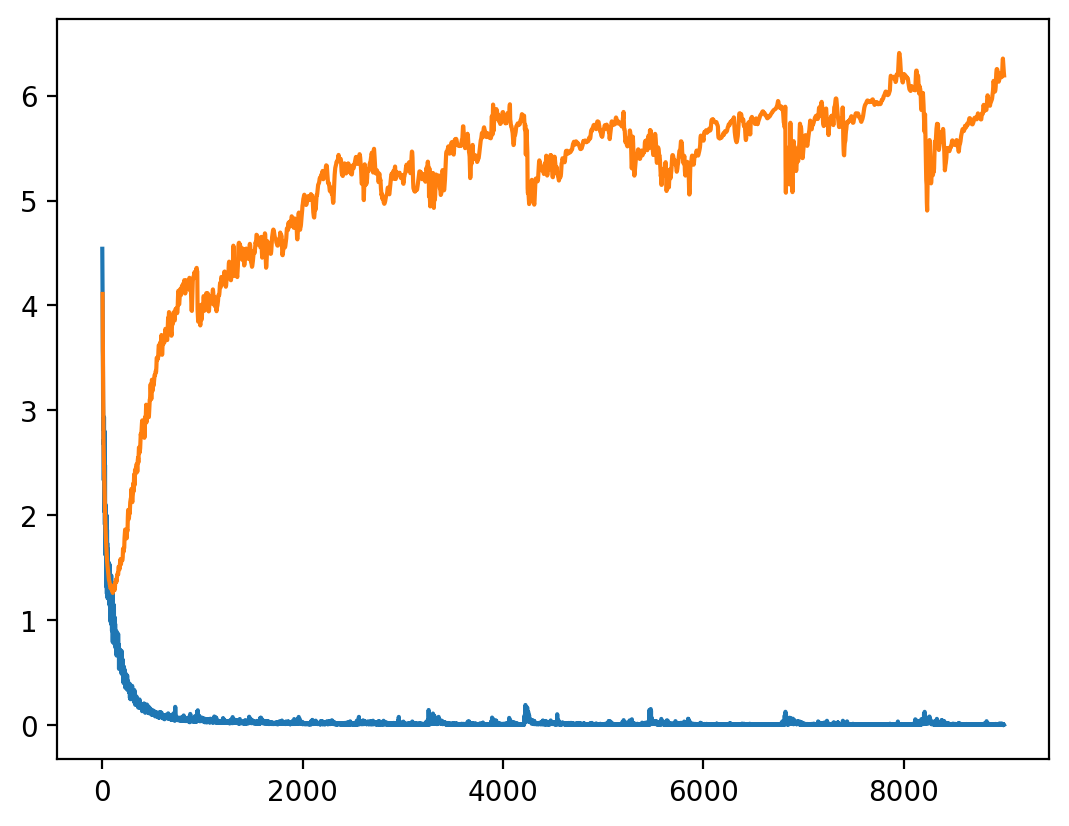

In [80]:
plt.plot(train_loss)
plt.plot(list(range(3, total_calc + 3, 3)), valid_loss)

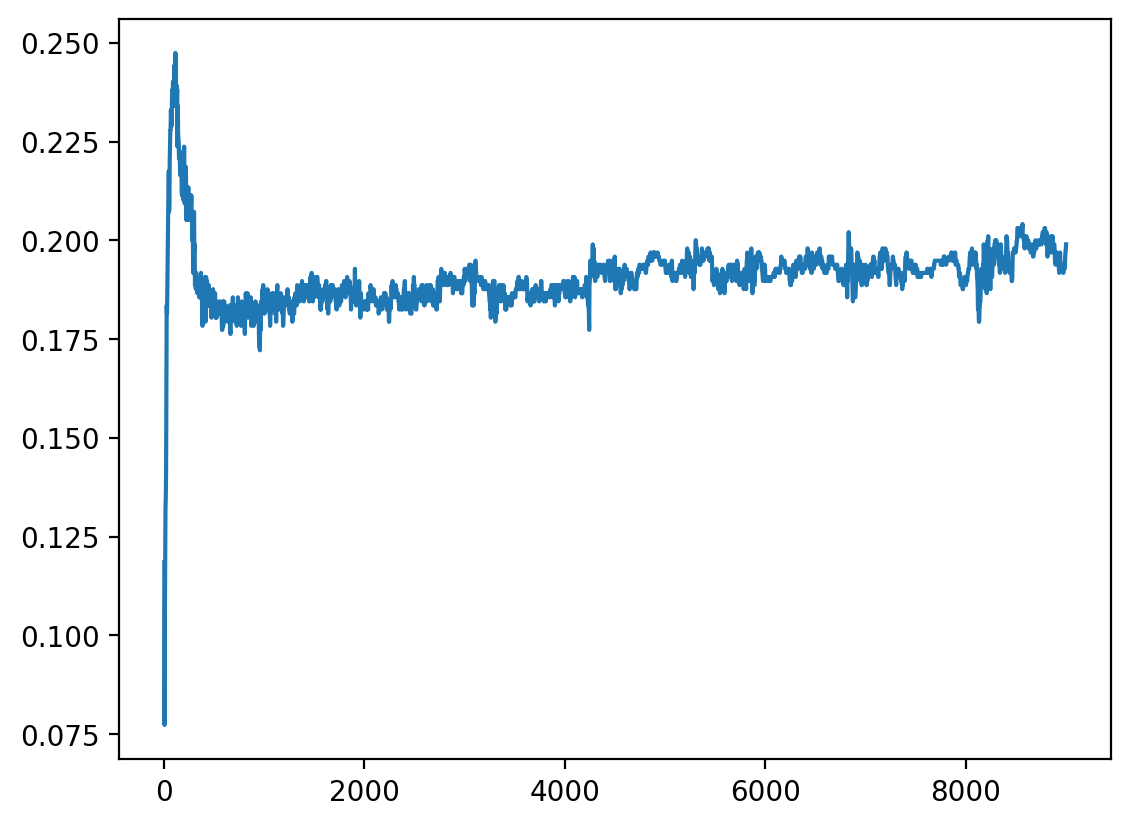

In [81]:
plt.plot(list(range(3, total_calc + 3, 3)), trainer.validation_acc)